# Iowa Housing Pricing: Modeling & Analysis

### Contents


In [17]:
# Import packages etc.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Import data
x_train = pd.read_csv('ITrain_DSet.csv').drop(['Unnamed: 0'], axis=1)
y_train = pd.read_csv('ITrain_Test.csv').drop(['Unnamed: 0'], axis=1)
x_test = pd.read_csv('ITTest_DSet.csv').drop(['Unnamed: 0'], axis=1)
y_test = pd.read_csv('ITTest_Test.csv').drop(['Unnamed: 0'], axis=1)
sample_result = pd.read_csv('sample_submission.csv')
testset = pd.read_csv('test.csv')


In [18]:
for dat in [x_train, y_train, x_test, y_test]:
    print(dat.shape)

(1168, 265)
(1168, 1)
(292, 265)
(292, 1)


# Processing & Scaling

In [19]:
from sklearn.preprocessing import StandardScaler
import pickle

# scale data
scale = StandardScaler()
x_train = pd.DataFrame(scale.fit_transform(x_train),   # Fit & Transform Train
                      columns=x_train.columns.to_list())
x_test = pd.DataFrame(scale.transform(x_test),         # Transform Test Per Train
                     columns=x_test.columns.to_list())
pickle.dump(scale, open('./scale.pkl', 'wb'))          # Save Scale Pickle

In [21]:
from sklearn import linear_model, svm, ensemble, model_selection
import xgboost as xgb

##################################
### Prepare Modeling Materials ###
##################################

# Define Range of Models
ridge = linear_model.Ridge()
svr = svm.SVR()
randomForest = ensemble.RandomForestRegressor(n_jobs = -2,random_state = 430)
gradientBoost = ensemble.GradientBoostingRegressor(random_state = 430)
xgForest = xgb.XGBRFRegressor(n_jobs = -2, random_state = 430)
xgBooster = xgb.XGBRegressor(n_jobs = -2, random_state = 430)

# Collect Models
models = [ridge, svr, randomForest, gradientBoost,
         xgForest, xgBooster]

# Make results df
resul = pd.DataFrame(columns = ['Model', 'Ridge', 'SVR', 'RForest', 'GBoost', 'XGRForest', 'XGBoost'])
resul.set_index("Model", inplace = True)
resul.loc['StandardTrain'] = [0, 0, 0, 0, 0, 0]
resul.loc['StandardTest'] = [0, 0, 0, 0, 0, 0]
resul.loc['GSTunedTrain'] = [0, 0, 0, 0, 0, 0]
resul.loc['GSTunedTest'] = [0, 0, 0, 0, 0, 0]

##########################################
### Build & Test Models w/o GridSearch ###
##########################################

col = 0
for model in models:
    model.fit(x_train, y_train['SalePrice'])
    resul.iloc[0, col] = model.score(x_train, y_train['SalePrice'])
    resul.iloc[1, col] = model.score(x_test, y_test['SalePrice'])
    col += 1

resul.head()

,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
GSTunedTrain,0,0,0,0,0,0
GSTunedTest,0,0,0,0,0,0


# Analysis

In [ ]:
##############################
### Reset Model Collection ###
##############################

# Define Range of Models
ridge = linear_model.Ridge()
svr = svm.SVR()
randomForest = ensemble.RandomForestRegressor(n_jobs = -2,random_state = 430)
gradientBoost = ensemble.GradientBoostingRegressor(random_state = 430)
xgForest = xgb.XGBRFRegressor(n_jobs = -2, random_state = 430)
xgBooster = xgb.XGBRegressor(n_jobs = -2, random_state = 430)

# Collect Models
models = [ridge, svr, randomForest, gradientBoost,
         xgForest, xgBooster]



# Train Initial Regressive Models
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)

In order to attempt a broad analysis of our data, we will include classical, sklearn regression techniques, ranging from **Ridge & Lasso regressions** to svm's **Support Vector Regression**, and further to ensemble's **Random Forest Regressor** as well as **Gradient Boosting Regressor**.

We will complement our analysis with the popular *XGBoost* **Random Forest Regressor** and **Gradient Boosting Regressor** to compare their results with those of the native sklearn package.

In [28]:
from sklearn import linear_model, svm, ensemble
import xgboost as xgb

#####################
### Define Models ###
#####################

ridge = linear_model.Ridge()
svr = svm.SVR()
randomForest = ensemble.RandomForestRegressor(n_jobs = -2,random_state = 430)
gradientBoost = ensemble.GradientBoostingRegressor(random_state = 430)
xgForest = xgb.XGBRFRegressor(n_jobs = -2, random_state = 430)
xgBooster = xgb.XGBRegressor(n_jobs = -2, random_state = 430)

models = [ridge, svr, randomForest, gradientBoost, xgForest, xgBooster]

# Make results df
resul = pd.DataFrame(columns = ['Model', 'Ridge', 'SVR', 'RForest', 'GBoost', 'XGRForest', 'XGBoost'])
resul.set_index("Model", inplace = True)
resul.loc['StandardTrain'] = [0, 0, 0, 0, 0, 0]
resul.loc['StandardTest'] = [0, 0, 0, 0, 0, 0]
resul.loc['GridSearchCVTrain'] = [0, 0, 0, 0, 0, 0]
resul.loc['GridSearchCVTest'] = [0, 0, 0, 0, 0, 0]

##########################################
### Build & Test Models w/o GridSearch ###
##########################################

col = 0
for model in models:
    model.fit(x_train, y_train['SalePrice'])
    resul.iloc[0, col] = model.score(x_train, y_train['SalePrice'])
    resul.iloc[1, col] = model.score(x_test, y_test['SalePrice'])
    col += 1

resul.head()

,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
GridSearchCVTrain,0,0,0,0,0,0
GridSearchCVTest,0,0,0,0,0,0


# Grid Searches
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)


In [30]:
###################
### Ridge Model ###
###################

# import new toys
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import model_selection

# reset items
ridge = linear_model.Ridge()
pca = PCA(random_state=430)

# pipe & search
ridge_grid = {'pca__n_components': range(50, x_train.shape[1]),
             'model__alpha': [0.01, 0.1, 1, 10, 100, 1000]}
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', ridge)])
gs_ridge = model_selection.GridSearchCV(pipeline, ridge_grid, n_jobs=-2, cv=3)
gs_ridge.fit(x_train, y_train['SalePrice'])
print('Ridge Regressor Params: ' + str(gs_ridge.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[2, 0] = gs_ridge.score(x_train, y_train['SalePrice'])
resul.iloc[3, 0] = gs_ridge.score(x_test, y_test['SalePrice'])
resul.head()

Ridge Regressor Params: {'model__alpha': 100, 'pca__n_components': 194}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
GridSearchCVTrain,0.905522,0,0,0,0,0
GridSearchCVTest,0.852623,0,0,0,0,0


In [31]:
############################
### Support Vector Model ###
############################

# reset items
svr = svm.SVR()
pca = PCA(random_state=430)

# pipe & search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', svr)])
svr_grid = {'pca__n_components': range(50, x_train.shape[1]),
           'model__kernel': ['linear', 'poly', 'rbf'],
           'model__C': [0.01, 0.1, 1, 10, 100, 1000],
           'model__gamma': ['scale']}
gs_svr = model_selection.GridSearchCV(pipeline, svr_grid, n_jobs=-2, cv=3)
gs_svr.fit(x_train, y_train['SalePrice'])
print('Ridge Regressor Params: ' + str(gs_svr.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[2, 1] = gs_svr.score(x_train, y_train['SalePrice'])
resul.iloc[3, 1] = gs_svr.score(x_test, y_test['SalePrice'])
resul.head()

Ridge Regressor Params: {'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'linear', 'pca__n_components': 206}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
GridSearchCVTrain,0.905522,0.850859,0,0,0,0
GridSearchCVTest,0.852623,0.864469,0,0,0,0


In [ ]:
###############################
### Random Forest Regressor ###
###############################

randomForest = ensemble.RandomForestRegressor(n_jobs = -2,random_state = 430)
pca = PCA(random_state=430)

# pipe & search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', randomForest)])
rf_grid = {'pca__n_components': range(50, x_train.shape[1]),
          'model__n_estimators': [500, 750, 1000],
          'model__max_features': ['auto', 'sqrt', 'log2'],
          'model__max_depth': [11, 13, 15, 17, 19, 21]}
gs_randomForest = model_selection.GridSearchCV(pipeline, rf_grid, n_jobs=-2, cv=3)
gs_randomForest.fit(x_train, y_train['SalePrice'])
print('RandomForest Params: ' + str(gs_randomForest.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[2, 2] = gs_randomForest.score(x_train, y_train['SalePrice'])
resul.iloc[3, 2] = gs_randomForest.score(x_test, y_test['SalePrice'])
resul.head()

In [ ]:
################################
### Gradient Boost Regressor ###
################################

gradientBoost = ensemble.GradientBoostingRegressor(random_state = 430)
pca = PCA(random_state=430)

# pipe & search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', gradientBoost)])
gb_grid = {'pca__n_components': range(50, x_train.shape[1]),
          'model__learning_rate': [0.01, 0.1, 1],
          'model__n_estimators': [500, 750, 1000],
          'max_depth': [2, 3, 4, 5, 6]}
gs_gradientBoost = model_selection.GridSearchCV(pipeline, gb_grid, n_jobs=-2, cv=3)
gs_gradientBoost.fit(x_train, y_train['SalePrice'])
print('GradientBoost Params: ' + str(gs_gradientBoost.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[2, 3] = gs_gradienBoost.score(x_train, y_train['SalePrice'])
resul.iloc[3, 3] = gs_gradienBoost.score(x_test, y_test['SalePrice'])
resul.head()

In [ ]:
#################################
### XGRandom Forest Regressor ###
#################################

xgForest = xgb.XGBRFRegressor(n_jobs = -2, random_state = 430)
pca = PCA(random_state=430)

# Pipe & Search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', xgForest)])
xgf_grid = {'pca__n_components': range(50, x_train.shape[1]),
           'model__n_estimators': [500, 750, 1000],
           'model__max_depth': [11, 13, 15, 17, 19, 21],
           'model__gamma': [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1],
           'model__learning_rate': [0.01, 0.1, 1, 10]}
gs_xgForest = model_selection.GridSearchCV(pipeline, xgf_grid, n_jobs=-2, cv=3)
gs_xgForest.fit(x_train, y_train['SalePrice'])
print('XGRandomForest Params: ' + str(gs_xgForest.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[2, 4] = gs_gradienBoost.score(x_train, y_train['SalePrice'])
resul.iloc[3, 4] = gs_gradienBoost.score(x_test, y_test['SalePrice'])
resul.head()

In [ ]:
#########################
### XGBoost Regressor ###
#########################

xgBooster = xgb.XGBRegressor(n_jobs = -2, random_state = 430)
pca = PCA(random_state=430)

# Pipe & Search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', xgBooster)])
xgb_grid = {'pca__n_components': range(50, x_train.shape[1]),
           'model__n_estimators': [500, 750, 1000],
           'model__max_depth': [2, 3, 4, 5, 6],
           'model__gamma': [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1],
           'model__learning_rate': [0.01, 0.1, 1]}
gs_xgBooster = model_selection.GridSearchCV(xgBooster, xgb_grid, n_jobs=-2, cv=3)
gs_xgBooster.fit(x_train, y_train['SalePrice'])
print('XGBooster Params: ' + str(gs_xgBooster.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[2, 5] = gs_xgBooster.score(x_train, y_train['SalePrice'])
resul.iloc[3, 5] = gs_xgBooster.score(x_test, y_test['SalePrice'])
resul.head()

# Hyperparameter Tuning

In [27]:
# for i in grid_list:
#     print(str(i.estimator).split('(')[0] + ': ' + str(i.best_params_) + '\n')

Ridge: {'alpha': 100}

SVR: {'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}

RandomForestRegressor: {'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 1000}

GradientBoostingRegressor: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 750}

XGBRFRegressor: {'gamma': 0, 'learning_rate': 1, 'max_depth': 9, 'n_estimators': 750}

XGBRegressor: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}



In [77]:
from sklearn.inspection import permutation_importance

# Find Permutation Importance of XGRF Best Est
perms = permutation_importance(gs_xgForest.best_estimator_, x_train, y_train['SalePrice'],
                              n_jobs=-2, random_state=430)

# Generate Permutation Importance DF
perm_imp = pd.DataFrame(columns = [['IMean', 'IStd']])
perm_imp['Importances'] = list(perms['importances'])
perm_imp['IMean'] = list(perms['importances_mean'])
perm_imp['IStd'] = list(perms['importances_std'])
perm_imp['Features'] = x_test.columns.to_list()
perm_imp.set_index(['Features'], inplace=True)
perm_imp.sort_values(by=('IMean',), ascending=False).head(10)

/home/theodore/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,IMean,IStd,Importances
Features,,,
"(OverallQual,)",0.372925,0.016567,"[0.3579368613283701, 0.35190786700804233, 0.37..."
"(GrLivArea,)",0.207630,0.007281,"[0.20367996990809345, 0.20014434792141367, 0.2..."
"(TotalBsmtSF,)",0.075011,0.004216,"[0.07210783692338296, 0.07057427294142216, 0.0..."
"(LotArea,)",0.015367,0.000777,"[0.014534662578325253, 0.015863999471529833, 0..."
"(MSSubClass_180,)",0.013002,0.000646,"[0.011775724111942165, 0.013648488379183976, 0..."
"(GarageArea,)",0.012004,0.000344,"[0.012231111397062233, 0.012388145183188426, 0..."
"(TotRmsAbvGrd,)",0.010664,0.000522,"[0.010673491805890944, 0.011173657738738685, 0..."
"(YrsSinceBlt,)",0.009825,0.000614,"[0.010880866151642188, 0.010037295907920796, 0..."
"(MSSubClass_70,)",0.009567,0.000647,"[0.010614573516230297, 0.009144259505470376, 0..."


In [74]:
gsrf_import = pd.DataFrame()
gsrf_import['Importances'] = list(gs_randomForest.best_estimator_.feature_importances_)
gsrf_import['Features'] = x_test.columns.to_list()
gsrf_import.set_index(['Features'], inplace=True)
gsrf_import.sort_values(by='Importances', ascending=False).head(10)

,Importances
Features,
OverallQual,0.090046
GrLivArea,0.076834
TotalBsmtSF,0.059206
GarageCars,0.055118
MSSubClass_180,0.049697
GarageArea,0.047056
MSSubClass_50,0.045141
MSSubClass_20,0.039728
YrsSinceBlt,0.035982


In [78]:
############################
### Pickling for Project ###
############################

pickle.dump(gs_ridge, open(f'./gsridge.pkl', 'wb'))
pickle.dump(gs_svr, open(f'./gssvr.pkl', 'wb'))
pickle.dump(gs_randomForest, open(f'./gsrforest.pkl', 'wb'))
pickle.dump(gs_gradienBoost, open(f'./gsgradient.pkl', 'wb'))
pickle.dump(gs_xgForest, open(f'./gsxgforest.pkl', 'wb'))
pickle.dump(gs_xgBooster, open(f'./gsxgbooster.pkl', 'wb'))

In [6]:
###############################
### Import Choicest Pickles ###
###############################

pic_rid = pickle.load(open('./gsridge.pkl', 'rb'))
pic_svr = pickle.load(open('./gssvr.pkl', 'rb'))
pic_rf = pickle.load(open('./gsrforest.pkl', 'rb'))
pic_gb = pickle.load(open('./gsgradient.pkl', 'rb'))
pic_xrf = pickle.load(open('./gsxgforest.pkl', 'rb'))
pic_xgb = pickle.load(open('./gsxgbooster.pkl', 'rb'))


In [8]:
from sklearn.inspection import permutation_importance

# Find Permutation Importance of XGRF Best Est
perms2 = permutation_importance(pic_rf.best_estimator_, x_train, y_train['SalePrice'],
                              n_jobs=-2, random_state=430)

# Generate Permutation Importance DF
perm_imp2 = pd.DataFrame(columns = [['IMean', 'IStd']])
perm_imp2['Importances'] = list(perms2['importances'])
perm_imp2['IMean'] = list(perms2['importances_mean'])
perm_imp2['IStd'] = list(perms2['importances_std'])
perm_imp2['Features'] = x_test.columns.to_list()
perm_imp2.set_index(['Features'], inplace=True)
perm_imp2.sort_values(by=('IMean',), ascending=False).head(10)

,IMean,IStd,Importances
Features,,,
"(GrLivArea,)",0.056023,0.001887,"[0.054399993809808866, 0.05372661652829169, 0...."
"(OverallQual,)",0.048962,0.001913,"[0.04887290513752385, 0.04626326710759221, 0.0..."
"(TotalBsmtSF,)",0.032637,0.001101,"[0.032188733284593596, 0.03189469499679487, 0...."
"(GarageCars,)",0.021960,0.000536,"[0.021252985364709653, 0.02259744247581108, 0...."
"(GarageArea,)",0.020727,0.000704,"[0.019798658299794436, 0.021106451778622026, 0..."
"(MSSubClass_50,)",0.018642,0.001063,"[0.017021094645157664, 0.018379231136688157, 0..."
"(MSSubClass_180,)",0.017651,0.000770,"[0.016159668206177313, 0.018065749571168466, 0..."
"(LotArea,)",0.015075,0.000843,"[0.014501985857209632, 0.015451006949911639, 0..."
"(MSSubClass_20,)",0.014868,0.000308,"[0.014491705558813517, 0.014618229826568019, 0..."


In [10]:
!cat data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [11]:
perm_imp2.sort_values(by=('IMean',), ascending=False).head(15)

,IMean,IStd,Importances
Features,,,
"(GrLivArea,)",0.056023,0.001887,"[0.054399993809808866, 0.05372661652829169, 0...."
"(OverallQual,)",0.048962,0.001913,"[0.04887290513752385, 0.04626326710759221, 0.0..."
"(TotalBsmtSF,)",0.032637,0.001101,"[0.032188733284593596, 0.03189469499679487, 0...."
"(GarageCars,)",0.021960,0.000536,"[0.021252985364709653, 0.02259744247581108, 0...."
"(GarageArea,)",0.020727,0.000704,"[0.019798658299794436, 0.021106451778622026, 0..."
"(MSSubClass_50,)",0.018642,0.001063,"[0.017021094645157664, 0.018379231136688157, 0..."
"(MSSubClass_180,)",0.017651,0.000770,"[0.016159668206177313, 0.018065749571168466, 0..."
"(LotArea,)",0.015075,0.000843,"[0.014501985857209632, 0.015451006949911639, 0..."
"(MSSubClass_20,)",0.014868,0.000308,"[0.014491705558813517, 0.014618229826568019, 0..."


In [14]:
perm_imp2.reset_index()

,Features,IMean,IStd,Importances
0,"(LotFrontage,)",0.008273,2.970512e-04,"[0.007879858663879302, 0.008028127351458858, 0..."
1,"(LotArea,)",0.015075,8.427356e-04,"[0.014501985857209632, 0.015451006949911639, 0..."
2,"(OverallQual,)",0.048962,1.912921e-03,"[0.04887290513752385, 0.04626326710759221, 0.0..."
3,"(OverallCond,)",0.002614,1.486495e-04,"[0.0025150137975402664, 0.0025377399651101973,..."
4,"(YrsSinceBlt,)",0.013851,2.893713e-04,"[0.01354652415903479, 0.014344434336876155, 0...."
...,...,...,...,...
199,"(BsmtExposure,)",0.000006,3.159221e-07,"[5.712483466591145e-06, 6.636694385608877e-06,..."
200,"(HeatingQC,)",0.000157,8.753361e-06,"[0.00015103807154037696, 0.0001675158411671429..."
201,"(KitchenQual,)",0.000046,1.967466e-06,"[4.377572862857004e-05, 4.6627510593921784e-05..."
202,"(FireplaceQu,)",0.001379,6.302572e-05,"[0.0014428280036383745, 0.0012953361322433077,..."


In [35]:
# Print Relative Best Scores & Parameters
grid_series.apply(lambda x: print(str(x.estimator).split('(')[0] + ' SCORE: ' + str(x.best_score_)))
print()
grid_series.apply(lambda x: print(str(x.estimator).split('(')[0] + ' Best Params: ' + str(x.best_params_)))

Ridge SCORE: 0.8842993940184842
Lasso SCORE: 0.8823425858564766
SVR SCORE: -0.018135511861319766
RandomForestRegressor SCORE: 0.8720405838067112
GradientBoostingRegressor SCORE: 0.906303798496013
XGBRFRegressor SCORE: 0.868762405535055
XGBRegressor SCORE: 0.8946824805446599

Ridge Best Params: {'alpha': 100.0}
Lasso Best Params: {'alpha': 100.0}
SVR Best Params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
RandomForestRegressor Best Params: {'criterion': 'mse', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 1000}
GradientBoostingRegressor Best Params: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'max_features': 5, 'n_estimators': 1000}
XGBRFRegressor Best Params: {'gamma': 0.0, 'learning_rate': 1, 'max_depth': 9, 'n_estimators': 500}
XGBRegressor Best Params: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}


Ridge            None
Lasso            None
SVR              None
RandomForest     None
GradientBoost    None
XGForest         None
XGBooster        None
dtype: object

### Analysis
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)

From here we can see that our best scores come at the feet of the XGBoost Regressor, the SKLearn Gradient Boost Regressor, and the Random Forest Regressor. For the next step, we will look at how these perform in the test data.

In [36]:
# Collect best predictive models
best_RandomForest = grid_series.RandomForest.best_estimator_
best_GradientBoost = grid_series.GradientBoost.best_estimator_
best_XGBRandomForest = grid_series.XGForest.best_estimator_
best_XGBRegressor = grid_series.XGBooster.best_estimator_

best_models = [best_RandomForest, best_GradientBoost, best_XGBRandomForest, best_XGBRegressor]
best_models = pd.Series(best_models, index = ['RandomForest', 'GradientBoost', 'XGForest', 'XGBoost'])

In [88]:
############################################
### Perform Cleaning & Import Pickle Jar ###
############################################

imputer = pickle.load(open('./imputer.pkl', 'rb'))
ohe = pickle.load(open('./ohe.pkl', 'rb'))
scale = pickle.load(open('./scale.pkl', 'rb'))
ordinal = pickle.load(open('./ordinal.pkl', 'rb'))

x_test = data_prep(x_test, imputer, ordinal, ohe, scale)

/home/theodore/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Compare with Testing
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)


In [102]:
best_models.apply(lambda x: x.score(x_test, y_test['SalePrice']))

[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed:    0.1s
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed:    0.1s
[Parallel(n_jobs=11)]: Done 1000 out of 1000 | elapsed:    0.1s finished


RandomForest     0.836282
GradientBoost   -0.111301
XGForest         0.825947
XGBoost          0.792557
dtype: float64

In [103]:
gs_randomForest.best_params_

{'criterion': 'mse',
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 1000}

<AxesSubplot:xlabel='name'>

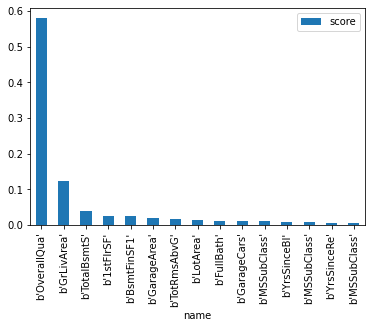

In [104]:
feature_importance = list(zip(x_test.columns, gs_randomForest.best_estimator_.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype = dtype)
feature_sort = np.sort(feature_importance, order = 'importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name, 'score':score})[:15].plot.bar(x = 'name', y = 'score')



# Make Predictions
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)



In [146]:
testset = pd.read_csv('test.csv')

In [147]:
testset.shape

(1459, 80)

In [148]:
testset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [149]:
testset = data_prep(testset, imputer, ordinal, ohe, scale)
rf_predictions = best_RandomForest.predict(testset)
rf_predictions = pd.DataFrame(rf_predictions).rename(columns = {0:'SalePrice'})

/home/theodore/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed:    0.1s
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed:    0.1s
[Parallel(n_jobs=11)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [150]:
rf_predictions

,SalePrice
0,122175.074431
1,146125.838607
2,161061.716860
3,167970.228044
4,196198.157914
...,...
1454,79880.487112
1455,87224.141011
1456,147346.763134
1457,108746.269380


In [151]:
# save info
pickle.dump(best_RandomForest, open('./bestRFmodel', 'wb'))
rf_predictions.to_csv('IowaHousingPredictions')